<a href="https://colab.research.google.com/github/talibilat/Univeristy-of-Essex/blob/main/CE889/CE889_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

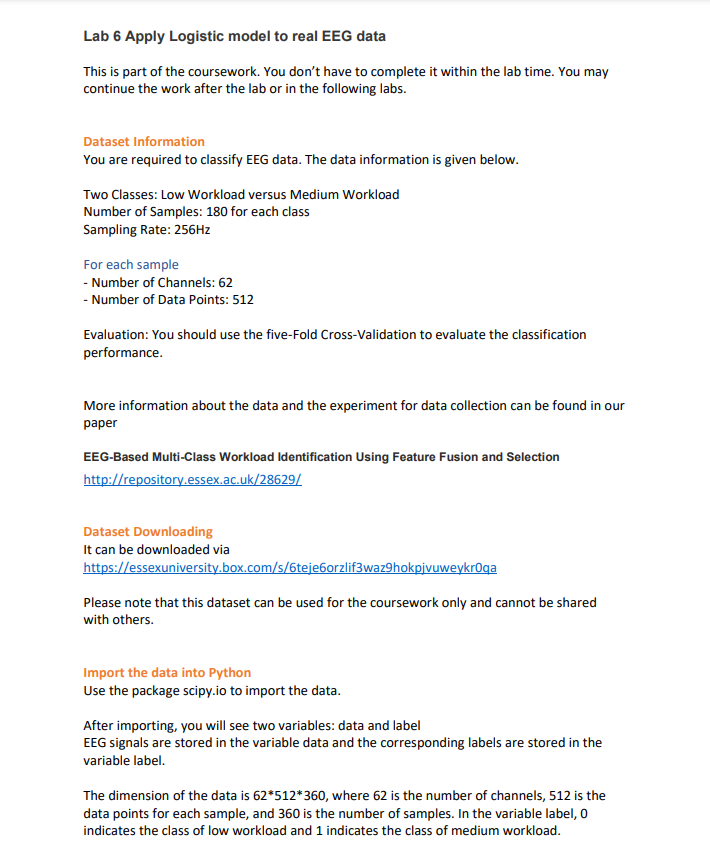

In [ ]:
import sklearn
from scipy._lib.doccer import indentcount_lines
import scipy.io as io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPClassifier
%matplotlib inline

# **Linear Model Building**
***Sigmoid***

In [ ]:
def sigmoid(z):
  sigmoid = 1/(1+np.exp(-z))
  #print('Sigmoid :', sigmoid)
  return sigmoid 

*Feed Forward*

In [ ]:
def forward_propogation(weights,x,bias):
 z = np.dot(weights.T, x) + bias
 y_hat = sigmoid(z)
#  print('Y_Hat :', y_hat.shape)
 return y_hat

*Gradient Descent*

In [ ]:
def gradients(x,y,y_hat):
  k = x.shape[0]
  w_derivative = (1/k)*(np.dot( x,(y_hat - y).T ))
  b_derivative = (1/k)*np.sum(y_hat - y)
  # print('W Derivative {}, B Derivative'.format(w_derivative,b_derivative))
  return w_derivative, b_derivative

*Weight and Bias Updation*

In [ ]:
def weight_bias_updation(w_derivative,b_derivative,learning_rate,weights,bias):
  weights = weights - (learning_rate * w_derivative)
  bias = bias - (learning_rate * b_derivative)
  #print('New weights : {}\n, New Bias :{}'.format(weights,bias))
  return weights,bias

*Loss Function*

In [ ]:
def log_loss(y,y_hat):
  loss =  -np.mean((y * np.log(y_hat)) + ((1-y) * np.log(1-y_hat)))
  # print('Loss :', str(loss))
  return loss

Model

In [ ]:
def train_model(x,y, loss):
  weights = np.full((31744,1),0.01) 
  bias = 0.01#np.full((1,1),0.01)  
  learning_rate = 0.0001
  iterations = 500
  loss_limit = 0.009
  for i in range(iterations):
    y_hat = forward_propogation(weights,x, bias)
    loss = log_loss(y,y_hat)
    w_derivative, b_derivative = gradients(x,y,y_hat)
    weights,bias = weight_bias_updation(w_derivative, b_derivative, learning_rate, weights, bias)
    # print('Weights : {}, Bias : {}, Loss : {}, Iteration : {}, Y_Hat{}'.format(weights[0,0], bias,loss,i,y_hat))
    if loss <= loss_limit:
      break
  return weights, bias, y_hat

Function for rounding off the output

In [ ]:
def roundoff_output(y_pred):

  y_roundoff = []
  for i in y_pred.flatten():
    if i >= 0.5:
      y_roundoff = np.append(y_roundoff,1)
    else:
      y_roundoff = np.append(y_roundoff,0)
  return y_roundoff


Importing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = io.loadmat("/content/drive/MyDrive/Colab Notebooks/WLDataCW.mat")                                              
print('The Length : ' + str(len(data)))                                         
print(data.keys())                                                               
print(data['__globals__'])
data_only = data['data']
label = data['label']
print("Shape of the data : ", data_only.shape)
print("DataType of the data : ", data_only.dtype)
print("Dimensions of the label : ", label.shape)
print("Type of the data : ", type(data_only))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The Length : 5
dict_keys(['__header__', '__version__', '__globals__', 'data', 'label'])
[]
Shape of the data :  (62, 512, 360)
DataType of the data :  float32
Dimensions of the label :  (1, 360)
Type of the data :  <class 'numpy.ndarray'>


Checking the Shapes of reshaped data


In [ ]:
data = data_only.reshape((62*512),360)
print("Shape of the data : ", data.shape)
print("Shape of the label : ",label.shape)


Shape of the data :  (31744, 360)
Shape of the label :  (1, 360)


In [ ]:
# df = pd.DataFrame(data)
# df.head()

In [ ]:
# df.T

In [ ]:
# df.isnull().sum().sum()

In [ ]:
# df.duplicated().sum()

In [ ]:
# df.describe(include="all").T


Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.T, label.T, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)

(288, 31744) (288, 1)


Standardize the data

In [ ]:
scaler = StandardScaler()
X_train_Scale = scaler.fit_transform(X_train)
X_test_Scale = scaler.transform(X_test)

*Training the model with 80% of Data and checking the accuracy*

In [ ]:
weights, bias, y_hat = train_model(X_train_Scale.T,y_train.T, 0.0)
y1 = roundoff_output(y_hat)
print(classification_report(y_train,y1))

              precision    recall  f1-score   support

           0       0.50      0.51      0.50       143
           1       0.50      0.49      0.50       145

    accuracy                           0.50       288
   macro avg       0.50      0.50      0.50       288
weighted avg       0.50      0.50      0.50       288



In [ ]:
ytest = forward_propogation(weights,X_test_Scale.T,bias)
y2 = roundoff_output(ytest)
print(classification_report(y_test,y2))

              precision    recall  f1-score   support

           0       0.47      0.41      0.43        37
           1       0.45      0.51      0.48        35

    accuracy                           0.46        72
   macro avg       0.46      0.46      0.46        72
weighted avg       0.46      0.46      0.46        72



In [ ]:
print(y2.shape,y_test.shape)

(72,) (72, 1)


##K-Fold

In [ ]:
model = MLPClassifier(max_iter=150)
model = model.fit(X_train,y_train.flatten())
y_pred = model.predict(X_train)
grid={'hidden_layer_sizes': [15],'activation':['logistic'],'alpha':[0.01],'learning_rate' : ['constant']} 
best_model=GridSearchCV(model,grid,cv=5)
ann_train = best_model.fit(X_train,y_train.flatten())
best_model.score(X_train,y_train)

# print(classification_report(y_train,y_pred))
# y_pred_test = model.predict(X_test)

# print(classification_report(y_test,y_pred_test))

In [ ]:
k_fold = KFold(n_splits=5)
k_fold.get_n_splits(X_train_Scale)
KFold(n_splits=5, random_state=None, shuffle=False)

KFold(n_splits=5, random_state=None, shuffle=False)

In [ ]:
for train_index, test_index in k_fold.split(X_train_Scale):
   X_train_new, X_test_new = X_train_Scale[train_index], X_train_Scale[test_index]
   y_train_new, y_test_new = y_train[train_index], y_train[test_index]
   weights, bias, y_pred_train = train_model(X_train_new.T,y_train_new.T,0.0)
   accuracies_train =[]
   accuracies_test = []
   ANN_accuracies_train = []
   ANN_accuracies_test = []

   label_predicted_train = roundoff_output(y_pred_train)

   accuracies_train = np.append(accuracies_train, metrics.accuracy_score(y_train_new,label_predicted_train))
  #  print('Accuracy(Train) :' , accuracies_train)





   y_pred_test = forward_propogation(weights,X_test_new.T,bias)
   label_predicted_test = roundoff_output(y_pred_test)
   accuracies_test = np.append(accuracies_test, metrics.accuracy_score(y_test_new,label_predicted_test))
  #  print('Accuracy(Test) :' , accuracies_test)

   print("XTrain", X_train_new.shape)
   print("Xtest", X_test_new.shape)
   print("YTrain", y_train_new.shape)
   print("YTest", y_test_new.shape)
   model = MLPClassifier(max_iter=150)
   model = best_model.fit(X_train_new,y_train_new.flatten())
   ANN_accuracies_train = np.append(ANN_accuracies_train, model.score(X_train_new,y_train_new))
   ANN_accuracies_test = np.append(ANN_accuracies_test, model.score(X_test_new,y_test_new))



accuracies_train = accuracies_train.mean()
accuracies_test = accuracies_test.mean()
ANN_accuracies_train = ANN_accuracies_train.mean()
ANN_accuracies_test = ANN_accuracies_test.mean()
print('Average accuracy for training data : {}\nAverage accuracy for test data : {} \nANN Average accuracy for train data : {}\nANN Average accuracy for test data : {}'.format(accuracies_train,accuracies_test,ANN_accuracies_train,ANN_accuracies_test)) 




XTrain (230, 31744)
Xtest (58, 31744)
YTrain (230, 1)
YTest (58, 1)
XTrain (230, 31744)
Xtest (58, 31744)
YTrain (230, 1)
YTest (58, 1)
XTrain (230, 31744)
Xtest (58, 31744)
YTrain (230, 1)
YTest (58, 1)
XTrain (231, 31744)
Xtest (57, 31744)
YTrain (231, 1)
YTest (57, 1)
XTrain (231, 31744)
Xtest (57, 31744)
YTrain (231, 1)
YTest (57, 1)
Average accuracy for training data : 0.49783549783549785
Average accuracy for test data : 0.5087719298245614 
ANN Average accuracy for train data : 0.9783549783549783
ANN Average accuracy for test data : 0.5614035087719298


In [ ]:
best_model.best_estimator_

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=15,
              max_iter=150)

0.84375